In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

from utils import tf_config

dataset="01"
memory_limit=1500
n_individuals=10
interval_eeg=10
seed=89#works: 2,3,5,21,34,89

tf_config.set_seed(seed=seed)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

import GPyOpt

import argparse

from utils import preprocess_data, search_algorithms, train, losses_utils, metrics, bnn_utils, eeg_utils, viz_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected, fourier_features

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

with tf.device('/CPU:0'):
    train_data, _ = preprocess_data.dataset(dataset, n_individuals=n_individuals,
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train,fmri_train=train_data

2021-12-30 10:23:19.670777: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-30 10:23:22.389985: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-30 10:23:22.394910: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-30 10:23:22.474073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 10:23:22.474973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce MX150 computeCapability: 6.1
coreClock: 1.5315GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 44.76GiB/s
2021-12-30 10:23:22.475063: I tensorflow/stream_executor/platform/default/dso_l

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


In [2]:
eeg_train = eeg_train[:100]
fmri_train = fmri_train[:100]

In [3]:
theta = (0.002980911194116198, 0.0004396489214334123, (9, 9, 4), (1, 1, 1), 1, (7, 7, 7), 4, True, True, True, True, 3, 1)
#unroll hyperparameters
learning_rate=float(theta[0])
weight_decay = float(theta[1])
kernel_size = theta[2]
stride_size = theta[3]
batch_size=int(theta[4])
latent_dimension=theta[5]
n_channels=int(theta[6])
max_pool=bool(theta[7])
batch_norm=bool(theta[8])
skip_connections=bool(theta[9])
dropout=bool(theta[10])
n_stacks=int(theta[11])
outfilter=int(theta[12])
local=True
na_specification = np.load("/home/david/eeg_to_fmri/na_models_eeg/na_specification_2", allow_pickle=True)

In [4]:
import importlib
importlib.reload(eeg_to_fmri)

low_resolution_factor=2
resolution_decoder = (int(fmri_train.shape[1]/low_resolution_factor),
                     int(fmri_train.shape[2]/low_resolution_factor),
                     int(fmri_train.shape[3]/low_resolution_factor))

with tf.device('/CPU:0'):
    model = eeg_to_fmri.EEG_to_fMRI(latent_dimension, eeg_train.shape[1:], na_specification, n_channels,
                        weight_decay=weight_decay, skip_connections=True,
                        batch_norm=True, #dropout=False,
                        fourier_features=True,
                        random_fourier=False,
                        inverse_DFT=False, DFT=False,
                        variational_iDFT=False,
                        variational_coefs=(15,15,15),
                        low_resolution_decoder=False,
                        resolution_decoder=resolution_decoder,#experimenting
                        local=True, seed=None, 
                        fmri_args = (latent_dimension, fmri_train.shape[1:], 
                        kernel_size, stride_size, n_channels, 
                        max_pool, batch_norm, weight_decay, skip_connections,
                        n_stacks, True, False, outfilter, dropout, None, False, None))
    
    model.build(eeg_train.shape, fmri_train.shape)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = losses_utils.mae_cosine

    train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(batch_size)
    dev_set= tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(1)

In [5]:
loss_history = train.train(train_set, model, optimizer, 
                            loss_fn, epochs=10, 
                            u_architecture=True,
                            val_set=None, verbose=True, verbose_batch=False)[0]
#Epoch 10 with loss: 0.04774155244231224

2021-12-30 10:26:00.291402: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-12-30 10:26:02.282229: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-30 10:26:02.392549: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-30 10:26:02.731067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-30 10:26:03.311448: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


Epoch 1 with loss: 0.2593016955256462
Epoch 2 with loss: 0.07041795372962951
Epoch 3 with loss: 0.0629081792011857
Epoch 4 with loss: 0.058250369988381866
Epoch 5 with loss: 0.07100828144699335
Epoch 6 with loss: 0.06163975521922112
Epoch 7 with loss: 0.05625965639948845
Epoch 8 with loss: 0.04589700993150472
Epoch 9 with loss: 0.05047313652932644
Epoch 10 with loss: 0.04774155244231224


## Propagating EEG Relevances

In [6]:
from utils import lrp

explainer = lrp.LRP_EEG(model)
R=lrp.explain(explainer, dev_set, eeg=True, fmri=False, verbose=True)

## Mean of population plot

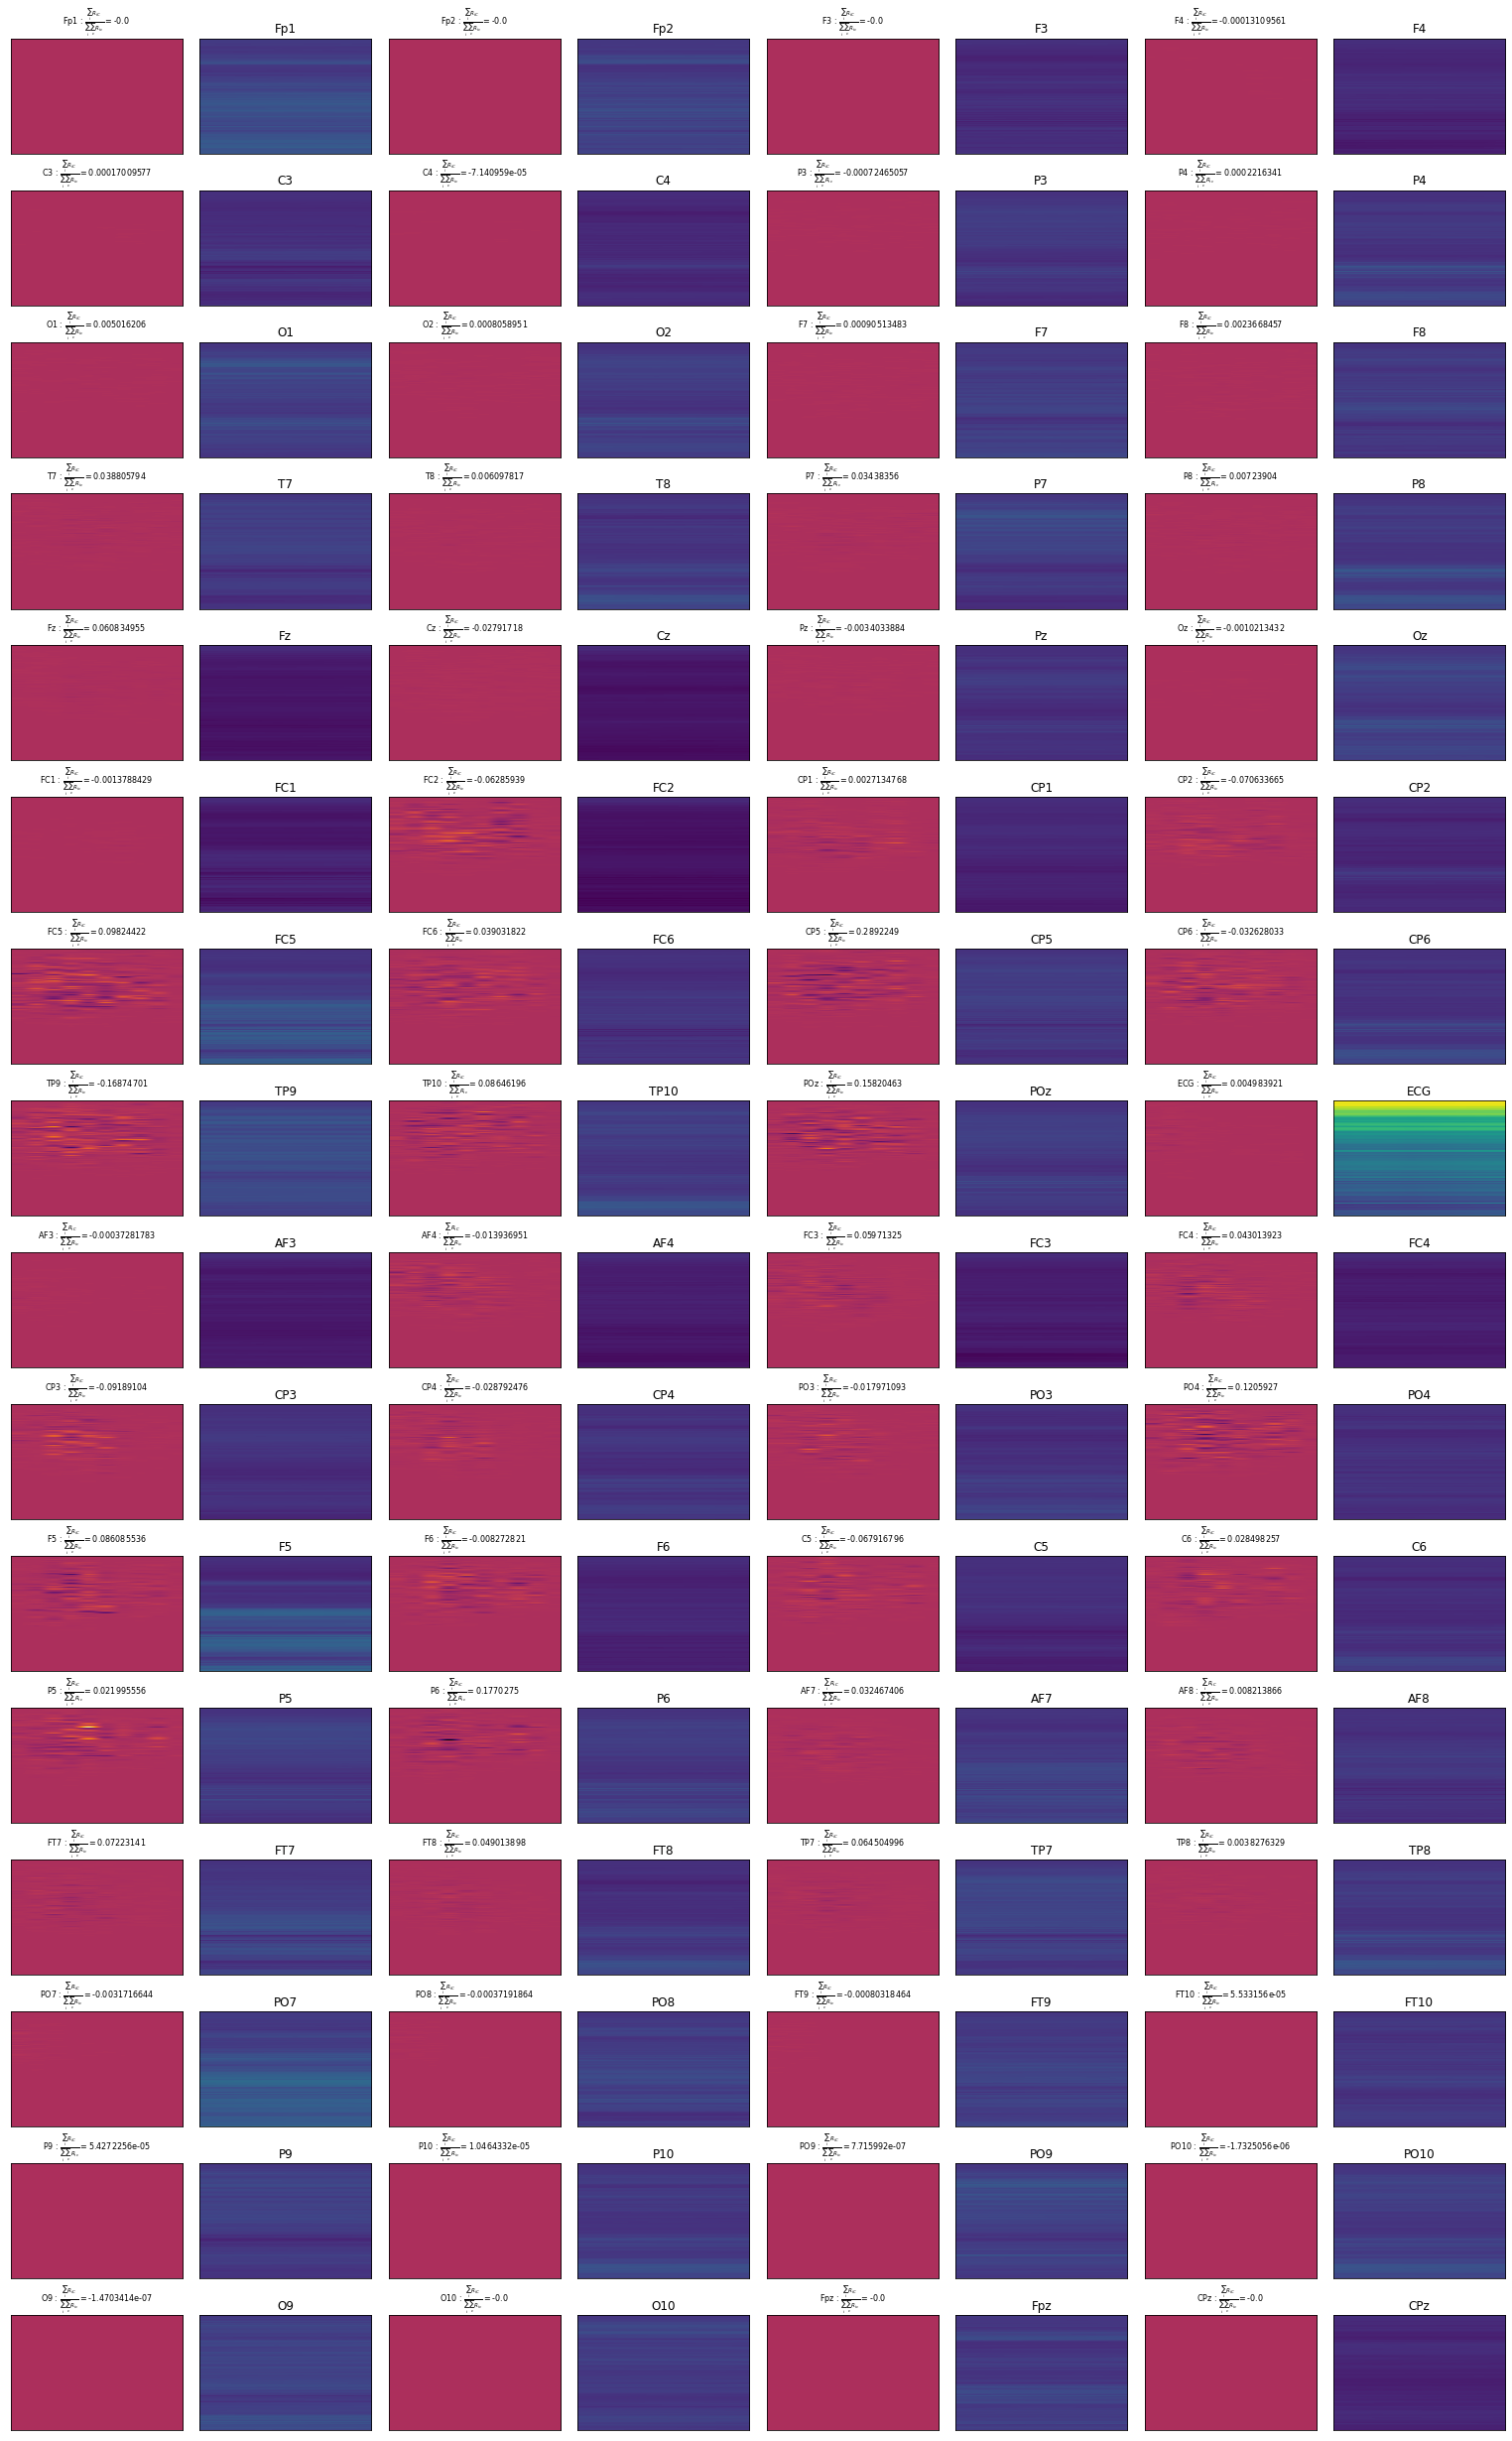

In [7]:
importlib.reload(viz_utils)
viz_utils.R_channels(R, eeg_train, ch_names=eeg_utils.channels_01,
                    save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/channels.pdf")

## P-value across channels

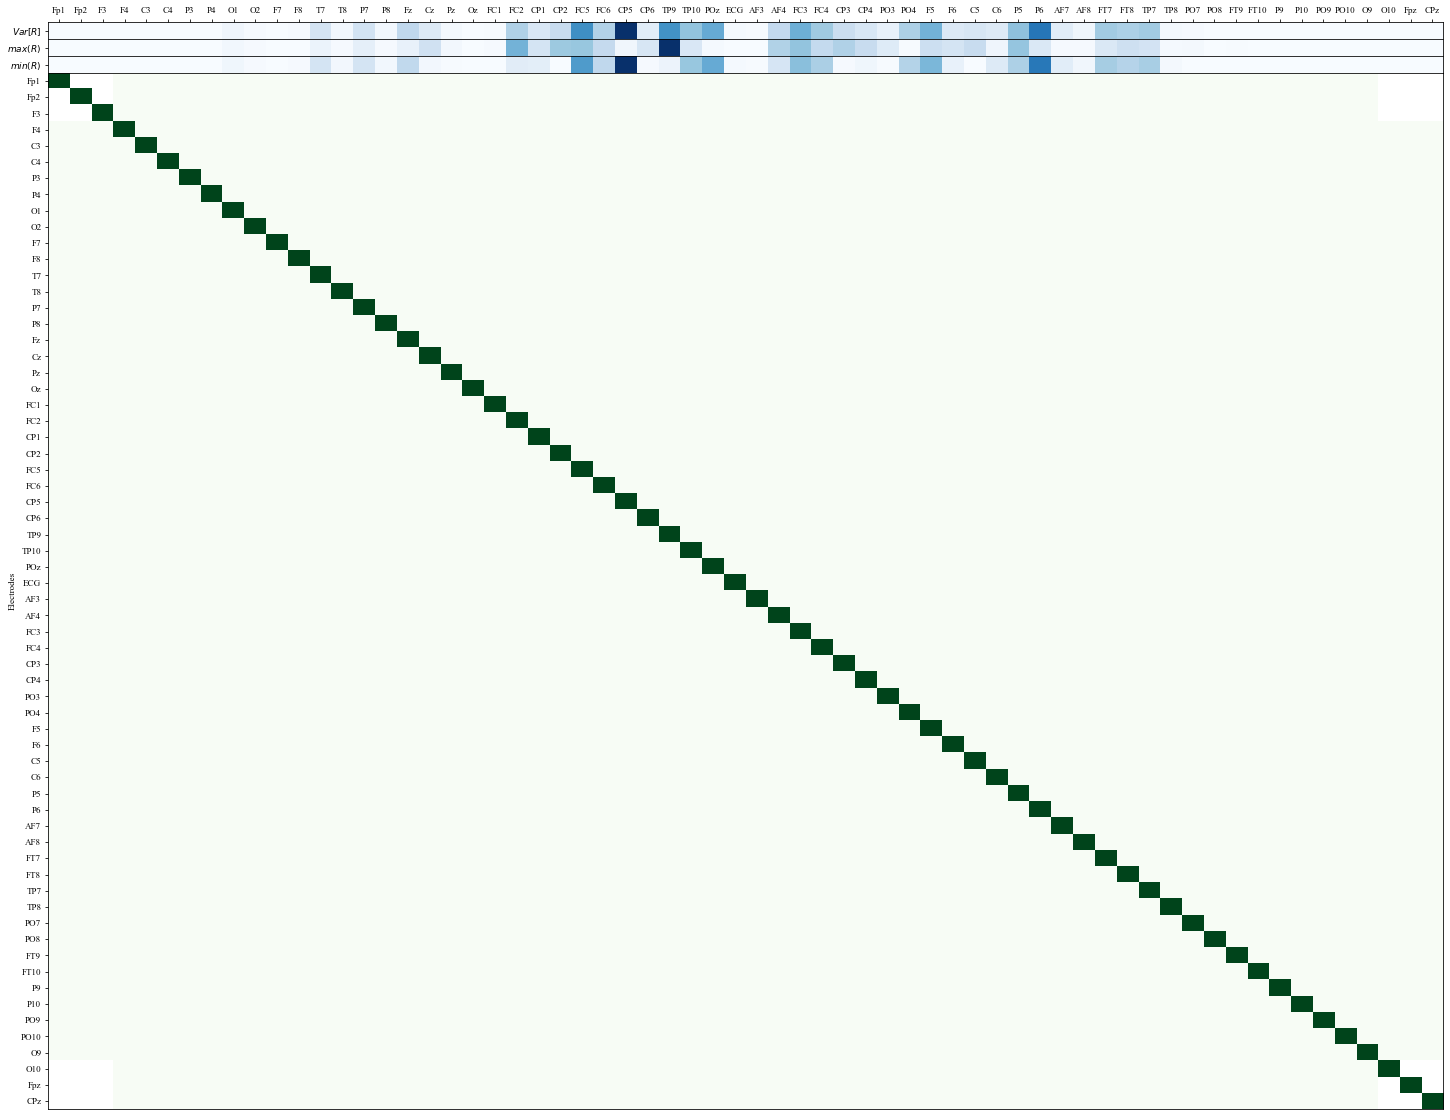

In [8]:
viz_utils.R_analysis_channels(R, eeg_train.shape[1], ch_names=getattr(eeg_utils, "channels_"+dataset),
                             save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/channels_relevance.pdf")

## P-value across frequencies

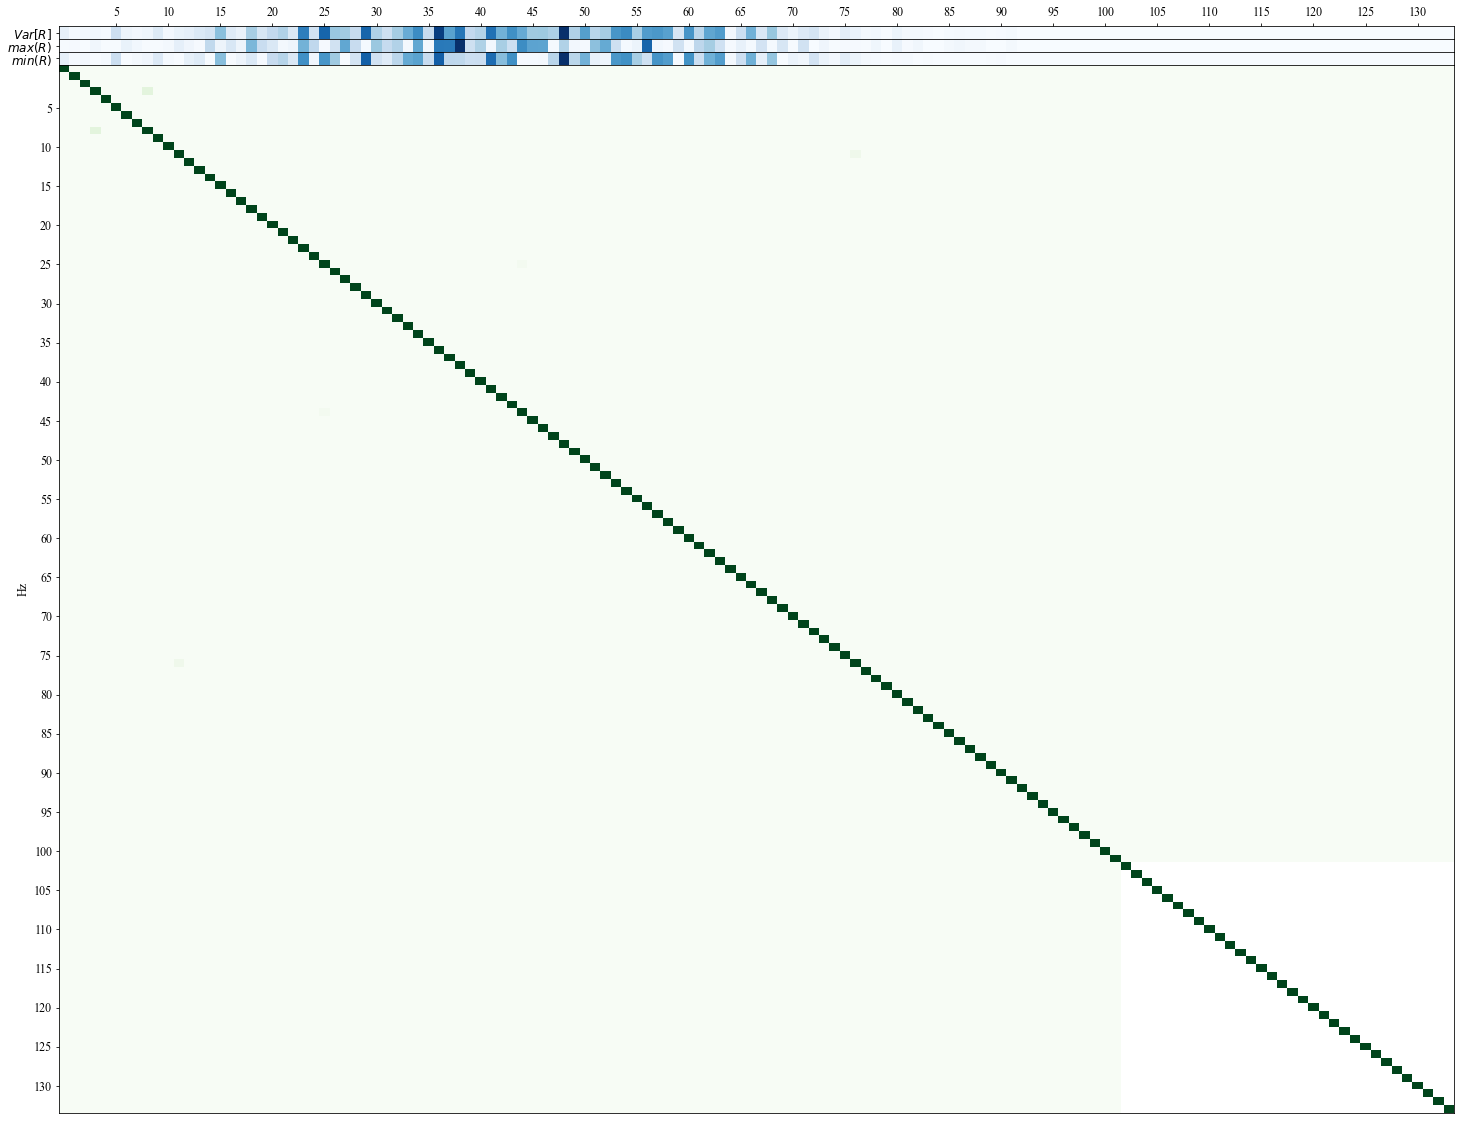

In [9]:
viz_utils.R_analysis_freqs(R, eeg_train.shape[2], 
                          save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/freq_relevance.pdf")

## P-value across time

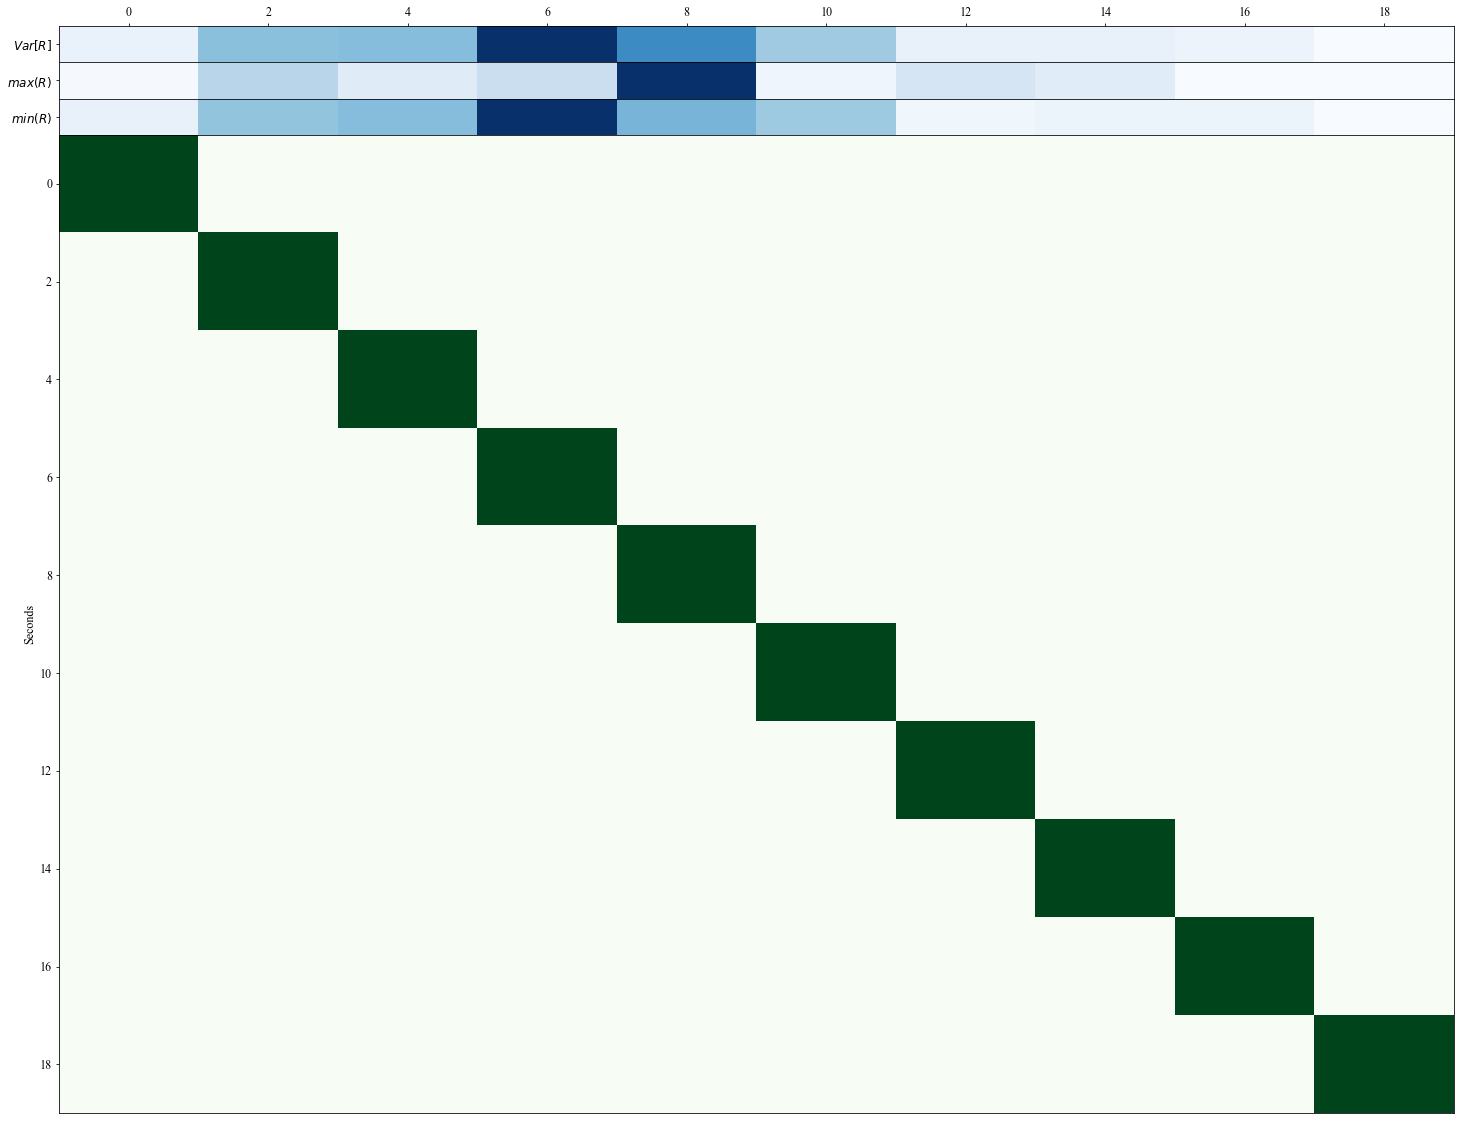

In [10]:
viz_utils.R_analysis_times(R, eeg_train.shape[3],
                          save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/time_relevance.pdf")

## Relevances analyses across dimensions

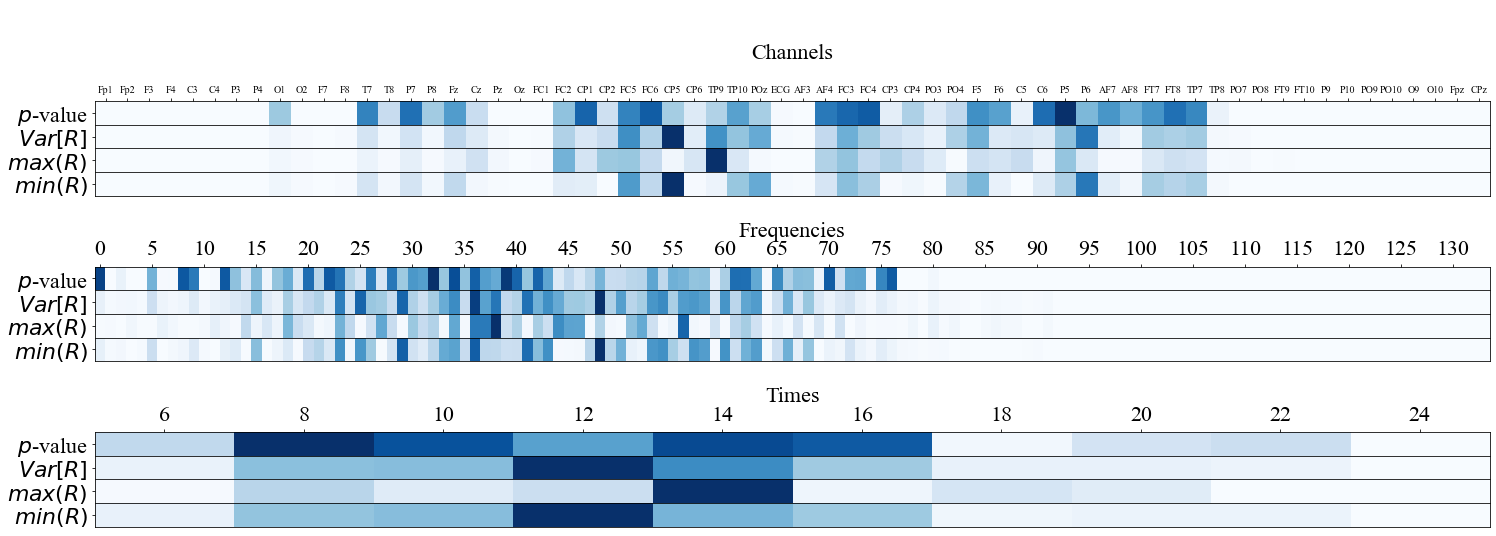

In [11]:
importlib.reload(viz_utils)

viz_utils.R_analysis_dimensions(R, ch_names=getattr(eeg_utils, "channels_"+dataset),
                               save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/relevance.pdf")

## Relevances analyses across time-frequency

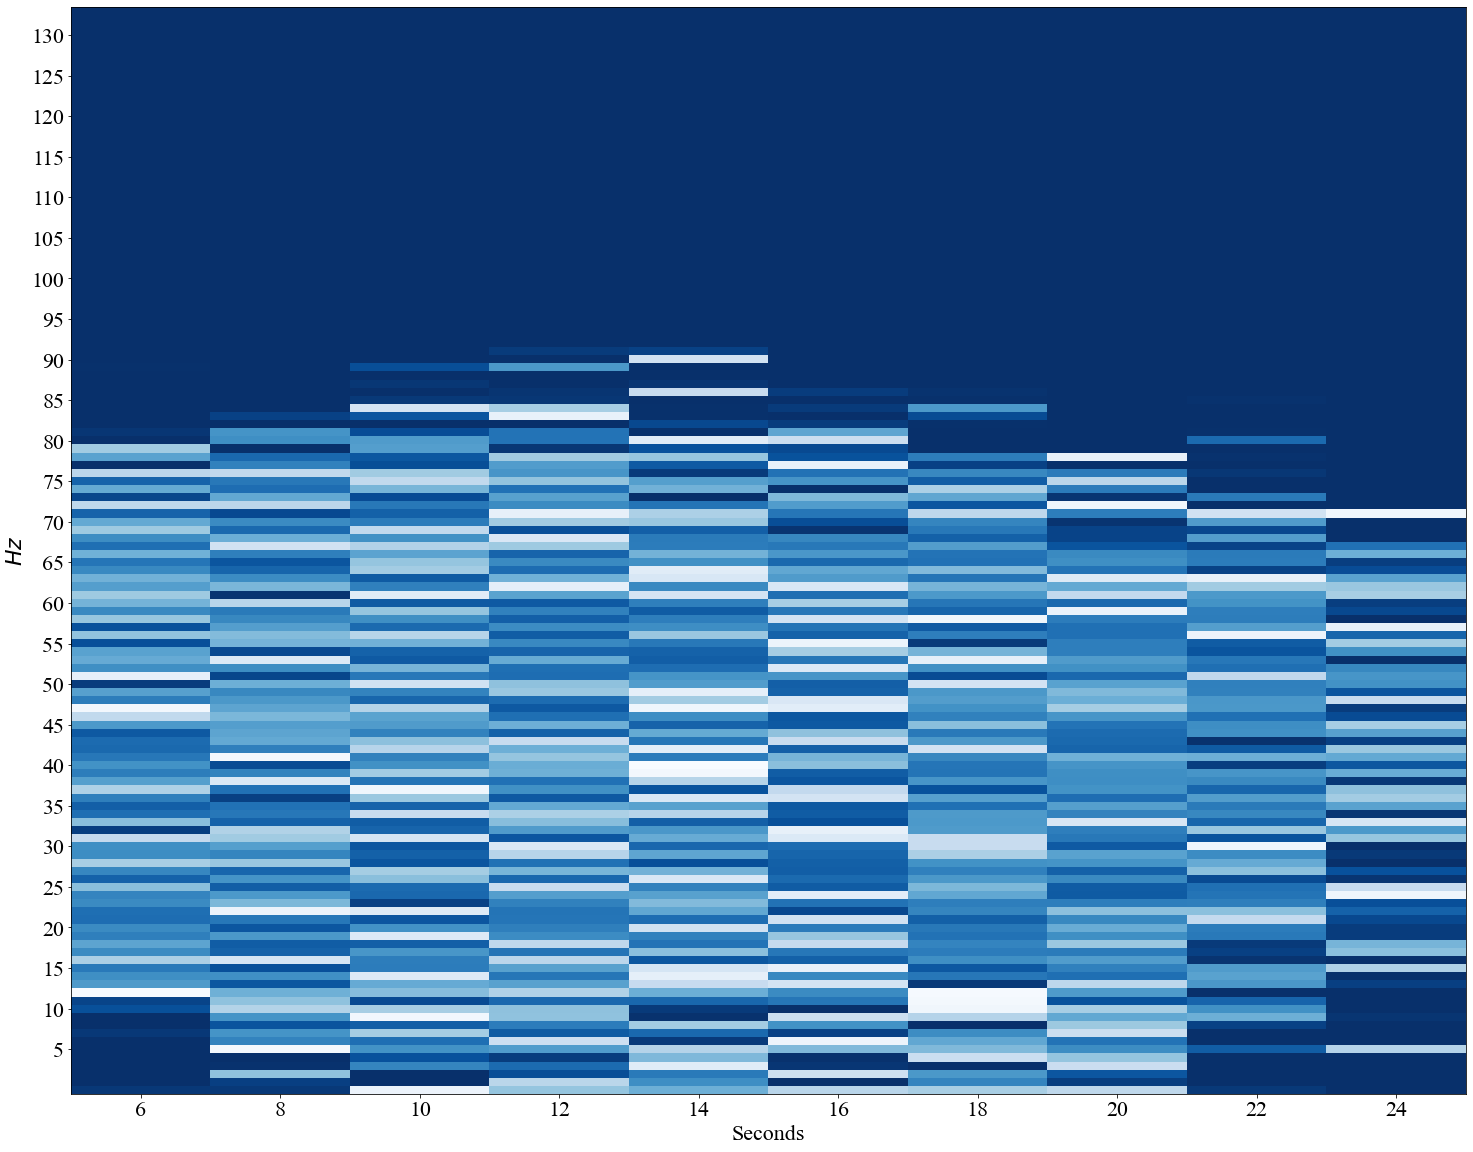

In [12]:
viz_utils.R_analysis_times_freqs(R, R.shape[3], R.shape[2], func=metrics.ttest_1samp_r,
                      save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/relevance_time_freq.pdf")

## Relevances analyses across channel-frequency

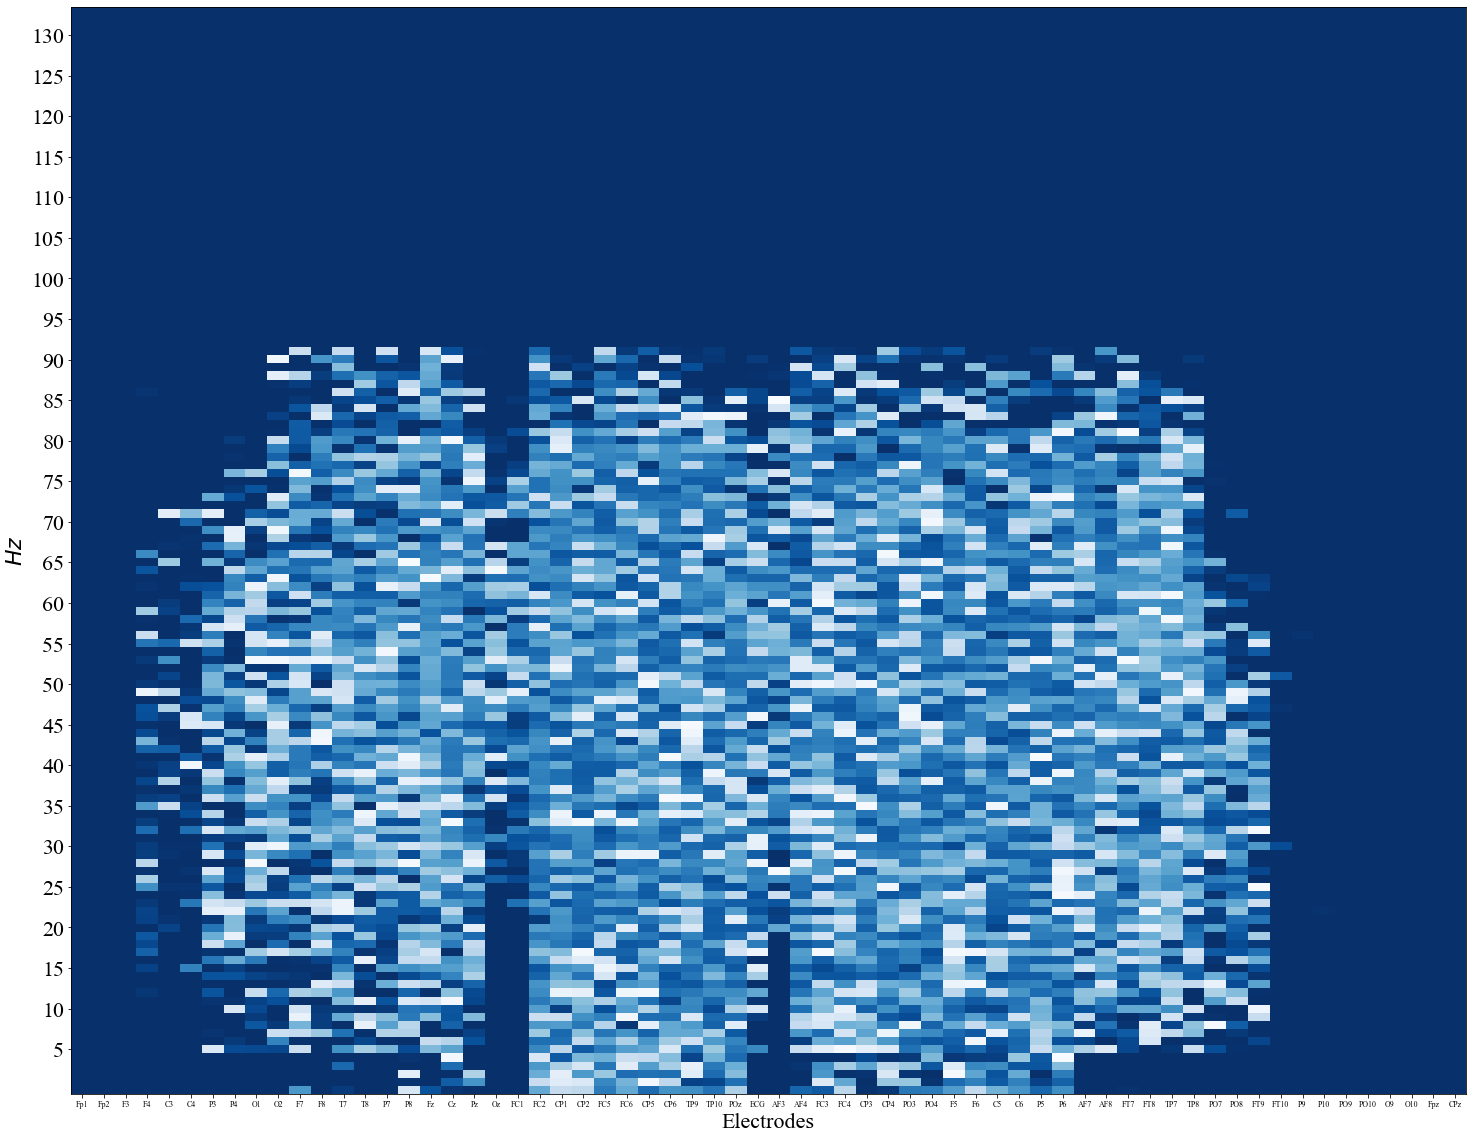

In [13]:
viz_utils.R_analysis_channels_freqs(R, R.shape[1], R.shape[2], func=metrics.ttest_1samp_r,
                         ch_names=getattr(eeg_utils, "channels_"+dataset),
                         save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/relevance_channel_freq.pdf")

## Relevances analyses across time-channel

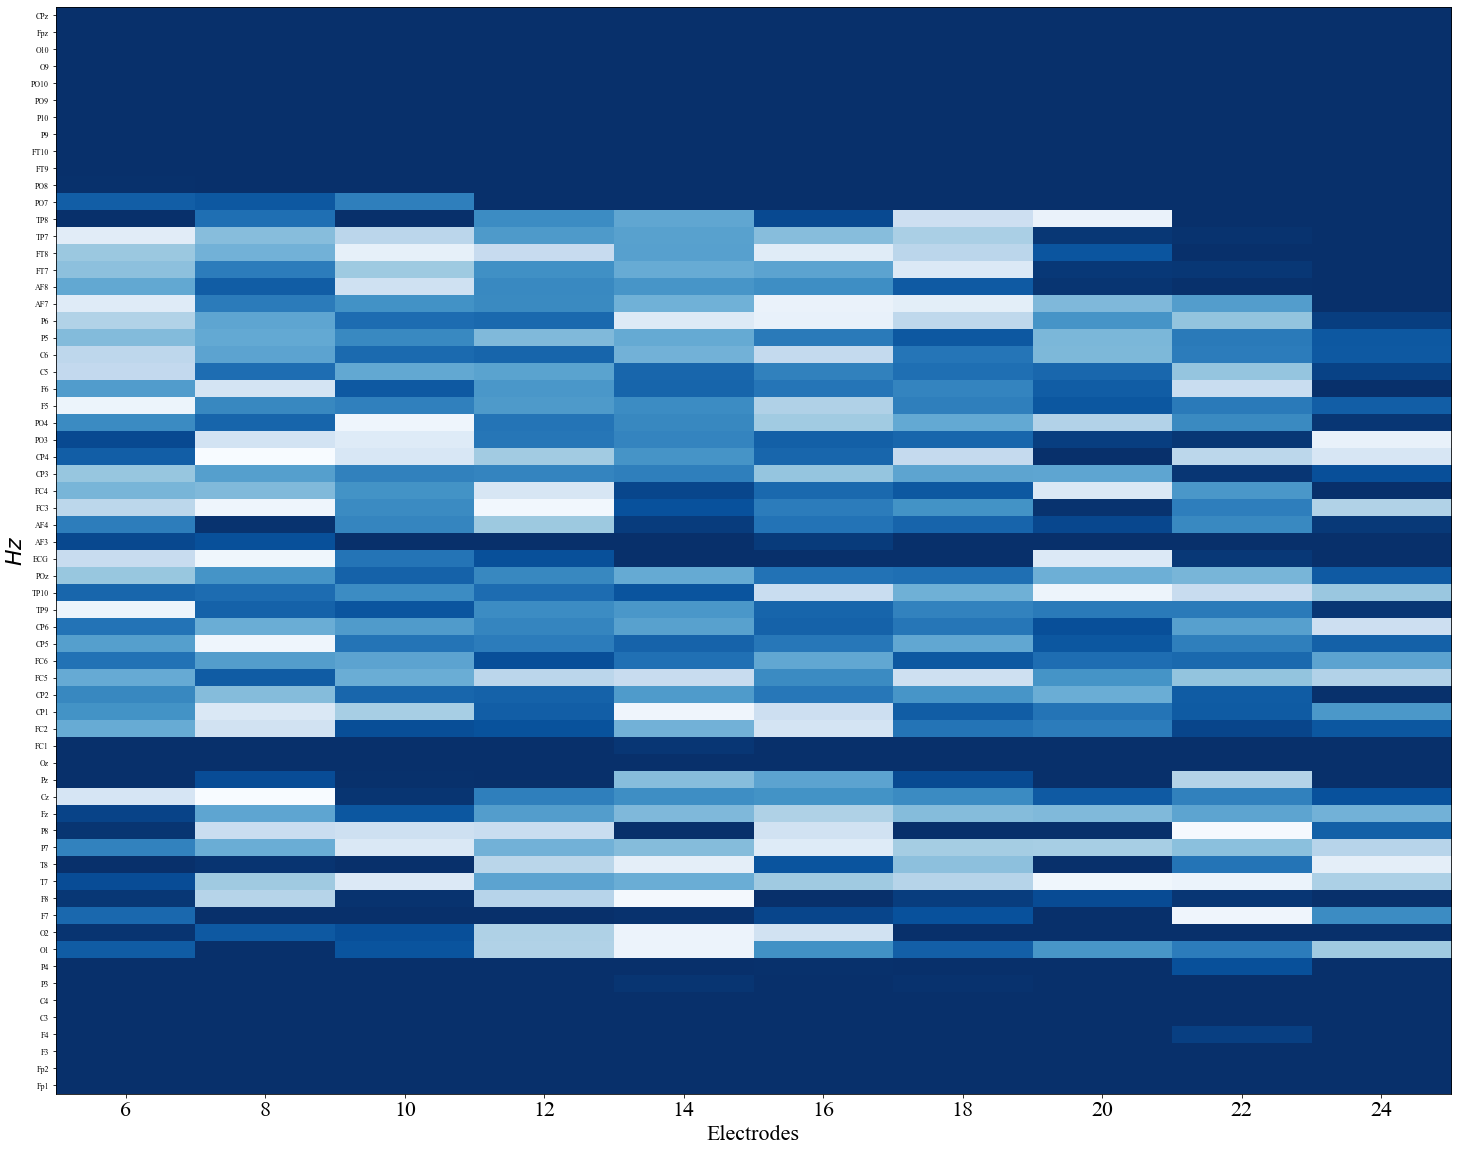

In [14]:
viz_utils.R_analysis_times_channels(R, R.shape[3], R.shape[1], func=metrics.ttest_1samp_r,
                         ch_names=getattr(eeg_utils, "channels_"+dataset),
                          save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/relevance_time_channel.pdf")

## Propagating fMRI Relevances

In [15]:
from utils import lrp
importlib.reload(lrp)

explainer = lrp.LRP(model.fmri_encoder)
R=lrp.explain(explainer, dev_set, eeg=False, fmri=True, verbose=True)

### Relevances Mean Population

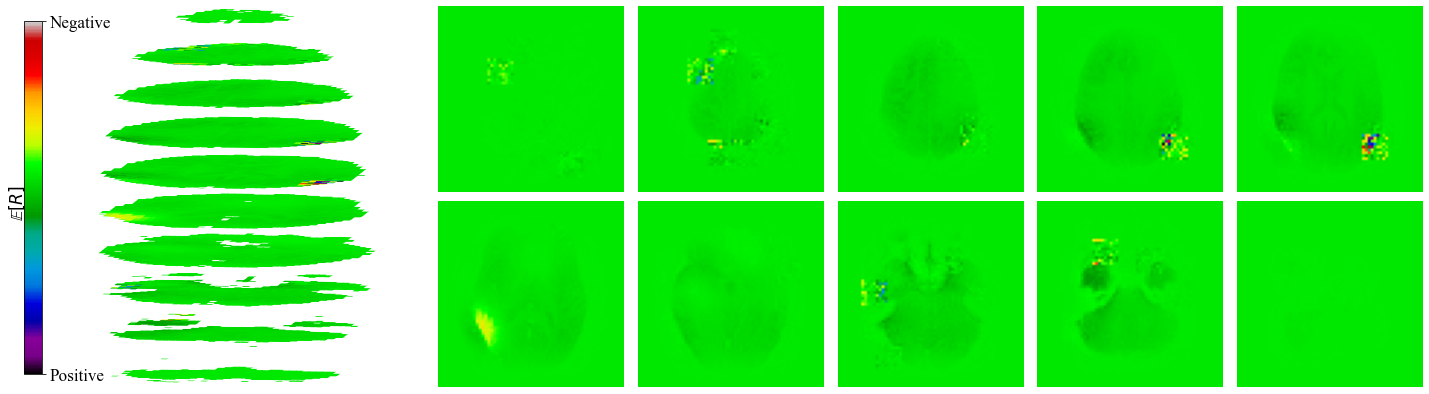

In [16]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/fmri_E_R.pdf",
                                                       max_min_legend=["Positive","Negative"])
fig.show()

### Relevances Variance

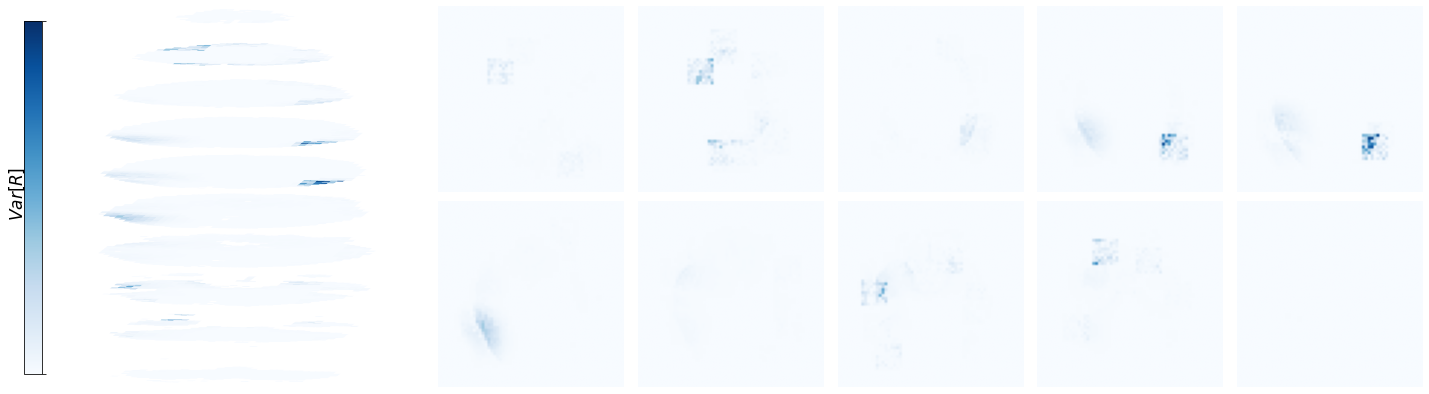

In [17]:
fig = viz_utils.plot_3D_representation_projected_slices(np.std(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                        cmap=plt.cm.Blues,
                                                       legend_colorbar=r"$Var[R]$",
                                                       max_min_legend=["",""],
                                                       save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/fmri_Var_R.pdf")
fig.show()

### Relevances Maximum

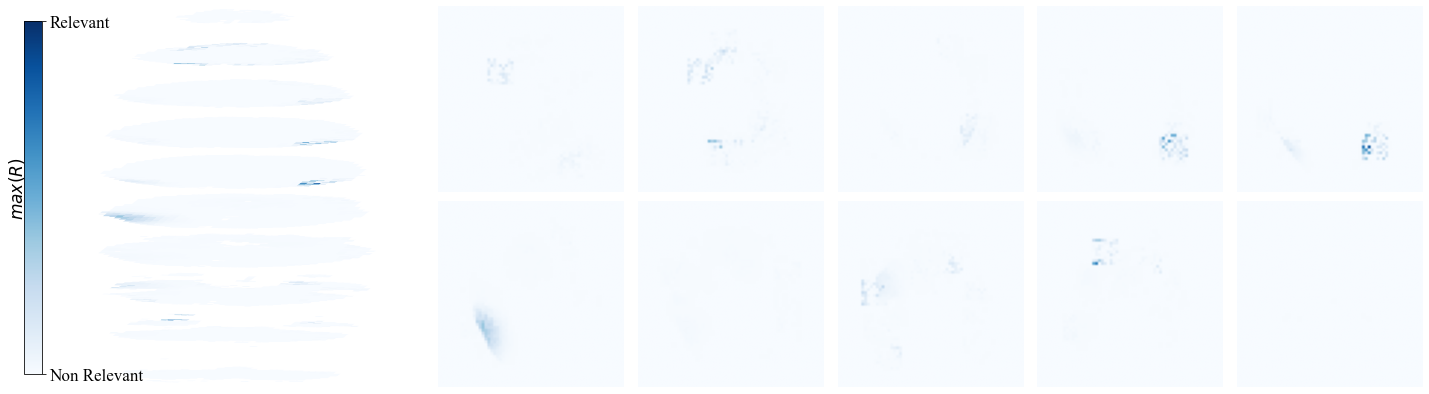

In [18]:
fig = viz_utils.plot_3D_representation_projected_slices(np.amax(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                        cmap=plt.cm.Blues,
                                                       legend_colorbar=r"$max(R)$",
                                                       max_min_legend=["Non Relevant","Relevant"],
                                                       save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/fmri_max_R.pdf")
fig.show()

### Relevances Minimum

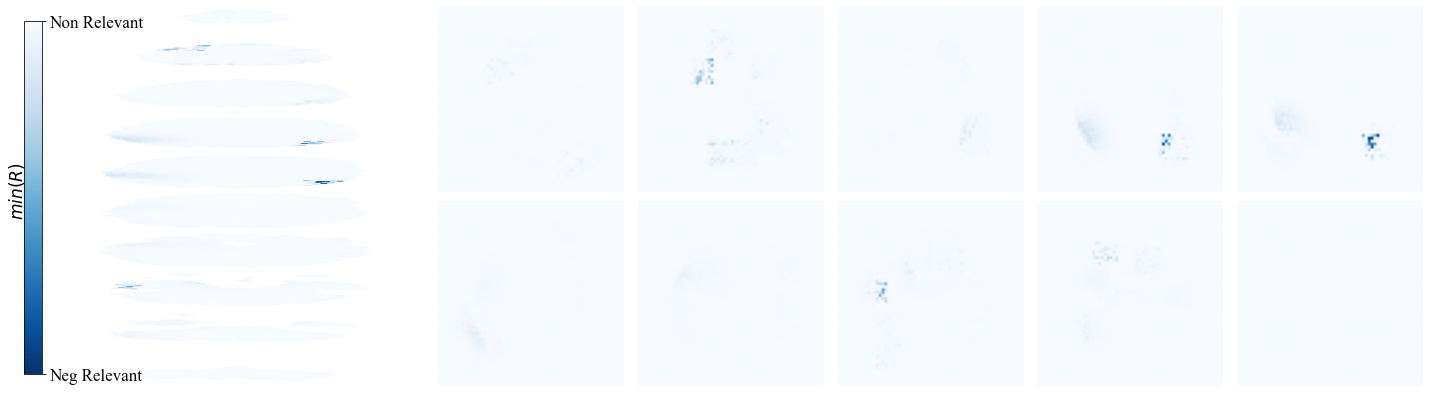

In [19]:
fig = viz_utils.plot_3D_representation_projected_slices(np.amin(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                        cmap=plt.cm.Blues_r,
                                                       legend_colorbar=r"$min(R)$",
                                                       max_min_legend=["Neg Relevant","Non Relevant"],
                                                       save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/fmri_min_R.pdf")
fig.show()

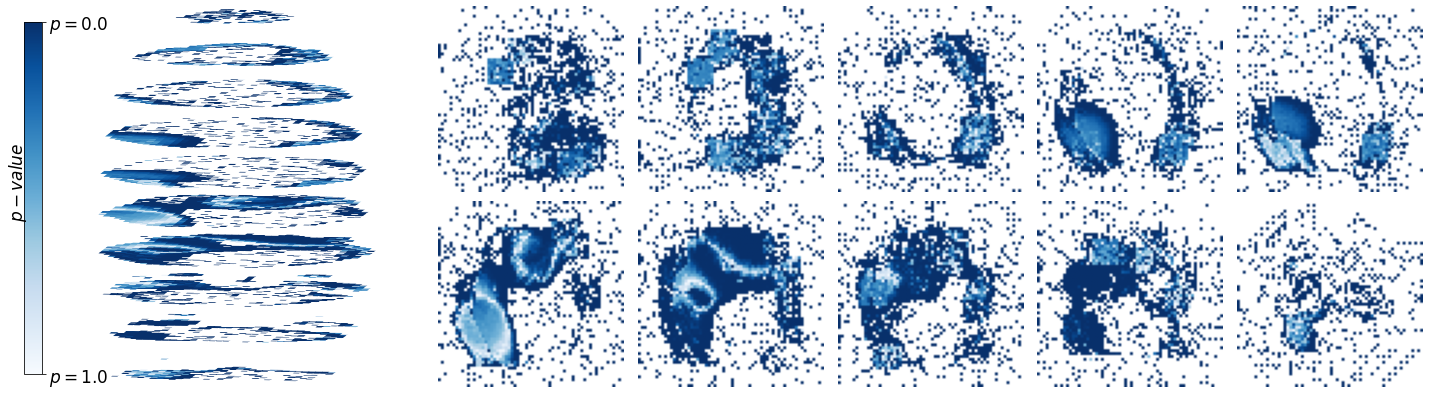

In [20]:
importlib.reload(metrics)
fig = viz_utils.plot_3D_representation_projected_slices(metrics.ttest_1samp_r(R, np.mean(R), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                        cmap=plt.cm.Blues,
                                                        legend_colorbar=r"$p-value$",
                                                        max_min_legend=[r"$p=1.0$",r"$p=0.0$"],
                                                        save=True, save_path="/home/david/eeg_to_fmri/plots/explainability/dct/fmri_min_R.pdf")
fig.savefig("/tmp/pvalue.png")